## Converting dicom chest x-ray files to png and executing registration


In [1]:
import os
import pyelastix
from PIL import Image
import numpy as np 
import cv2
import json
import pydicom
from os import path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

## Functions

In [2]:
# creates a new folder if it does not already exist
def new_dir(dirName):
    try:
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")

# saves patient and image metadata to a json file
def metadataToJson(fileName):
    dir = './Target/' + fileName
    ds = pydicom.dcmread(dir) 
    newName = fileName.replace(".dicom", ".json")
    jsonModel = ds.to_json()
    dir = './Target/' + newName
    jsonFile = open (dir, "w")
    jsonFile.write(jsonModel)
    jsonFile.close()

# creates an 8bit PNG image of the dicom file and saves it in two separate folders   
def dicomToPng(fileName):
    dir = './Target/' + fileName
    ds = pydicom.dcmread(dir) 
    newName = fileName.replace(".dicom", ".png")
    image = ds.pixel_array.astype(float)
    lut = pydicom.pixel_data_handlers.util.apply_modality_lut(image,ds).astype(np.uint16)
    lut = pydicom.pixel_data_handlers.util.apply_voi_lut(lut,ds).astype(np.uint16)
    lut = normalization(lut, (2 ** ds[0x0028,0x0101].value) -1 ) 
   
    
    if ds[0x0028,0x0004].value == "MONOCHROME1": #se i colori sono "in negativo" li inverto nell'immagine risultante
        lut = np.amax(lut) -lut #da correggere
    scaled_image = (np.maximum(lut, 0) / lut.max()) * 255.0 #ritorno a 8 bit 
    scaled_image = np.uint8(scaled_image)
    final_image = Image.fromarray(scaled_image)
    png = './Pngs/'
    tgt = './Target/'
    path1 = os.path.join(png, newName) 
    path2 = os.path.join(tgt, newName)
    final_image.save(path1, 'PNG')
    final_image.save(path2, 'PNG')
    print('file ' + newName + ' converted and saved')
    
    
# intended as contrast enhancement
def normalization(source,x):
	return cv2.normalize(source,None,0,x,cv2.NORM_MINMAX)

# sets the image shape during the conversion as 1024 x 1024 for every .png file
def shape_as(source, target_dims=(1024, 1024)):
	max_height = 1024
	max_width = 1024
	height,width = source.shape
    # only shrink if img is bigger than required
	if target_dims[0] < height or target_dims[1] < width:
		# get scaling factor
		scaling_factor = target_dims[0] / float(height)
		if target_dims[1]/float(width) < scaling_factor:
			scaling_factor = target_dims[1] / float(width)
		# resize image
		source = cv2.resize(source, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
	height,width = source.shape
	if target_dims[0] > height or target_dims[1] > width:
		delta_x = int((target_dims[0] - source.shape[0])/2)
		delta_y = int((target_dims[1] - source.shape[1])/2)
		if (delta_x > 0) or (delta_y > 0):
			source = cv2.copyMakeBorder(source,delta_x,delta_x,delta_y,delta_y,cv2.BORDER_CONSTANT,value=[0,0,0])
	return source

# shows results as matplotlib plots
def showresults(ref, tgt, reg):
    fig,(x1, x2, x3) = plt.subplots(1,3, figsize = (8, 4))
    x1.imshow(ref, cmap = 'gray')
    x1.set_title('Reference')
    x2.imshow(tgt, cmap = 'gray')
    x2.set_title('Target')
    x3.imshow(reg, cmap = 'gray')
    x3.set_title('Registered')

# target and reference are assumed numpy arrays of image files of the same resolution
def registration(target, reference, t):
    
    #internal elastix parameters
    params = pyelastix.get_default_params(type=t) #RIGID, AFFINE, BSPLINE
    params.NumberOfResolutions = 8
    params.AutomaticTransformInitialization = True
    params.AutomaticScalesEstimation = False
    params.NumberOfHistogramBins = 64
    params.MaximumStepLength = 4.0
    params.MaximumNumberOfIterations = 500

    registered, field = pyelastix.register(target, reference, params, verbose=0)
    return registered
  
  

## Execution Pipeline 

### Conversion

In [3]:
%%time
d = "./Target/"
for filename in os.listdir(d):
    if filename.endswith(".dicom") or filename.endswith(".dcm"):
        metadataToJson(filename)
        dicomToPng(filename)
    else:
        continue

file test_file_1.png converted and saved
file test_file_2.png converted and saved
file test_file_3.png converted and saved
file test_file_4.png converted and saved
file test_file_5.png converted and saved
file test_file_6.png converted and saved
Wall time: 16.7 s


### Rigid Registrations

Directory  Pngs  already exists
Directory  Registered_with_PyElastix  already exists
Found elastix version: 5.0.1 in 'elastix.exe'
Wall time: 7min 30s


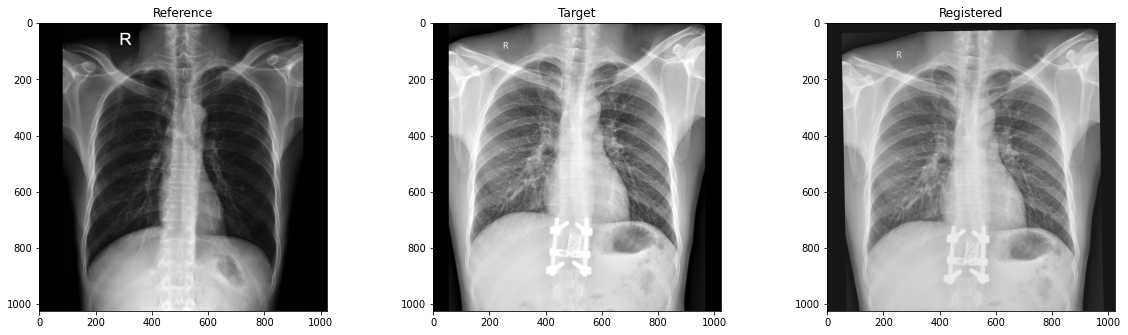

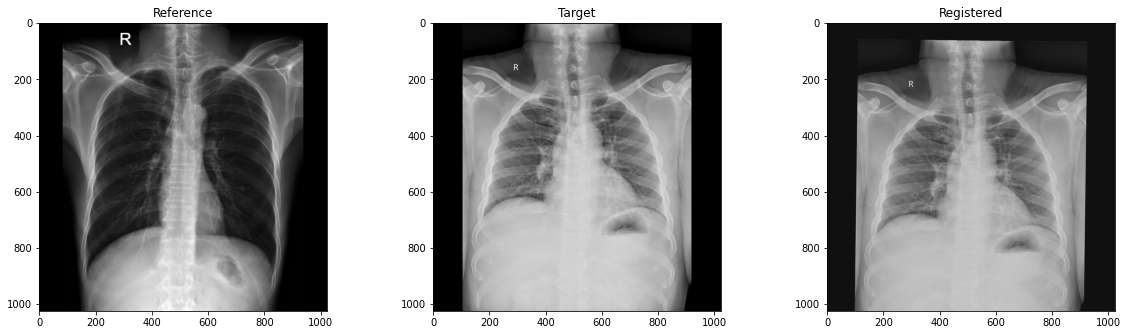

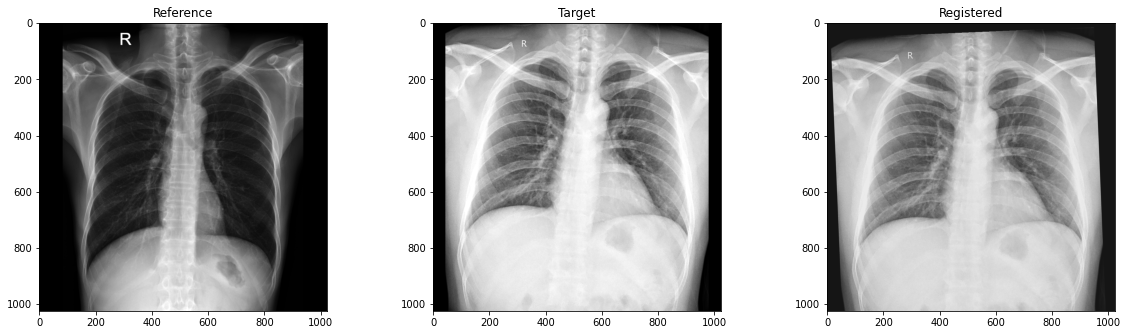

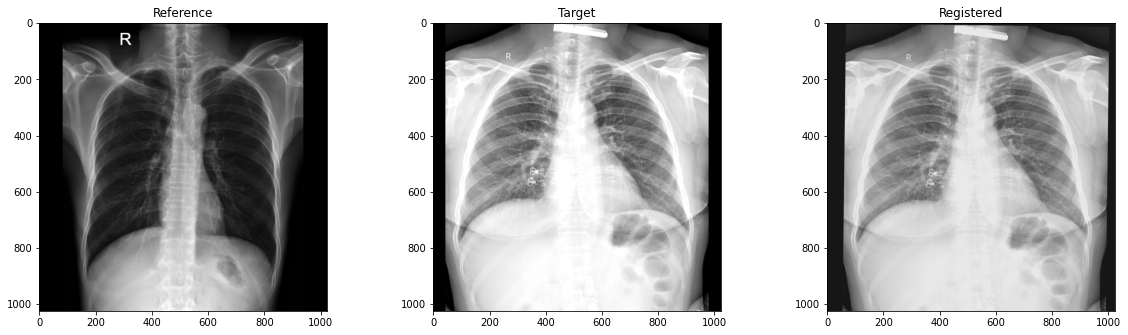

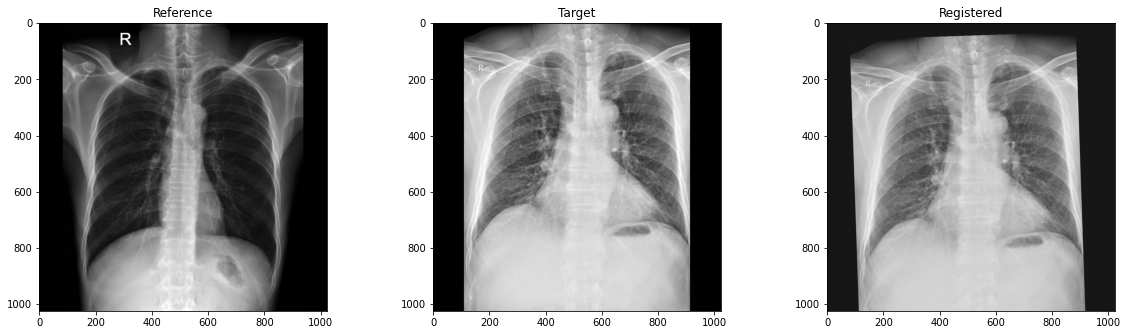

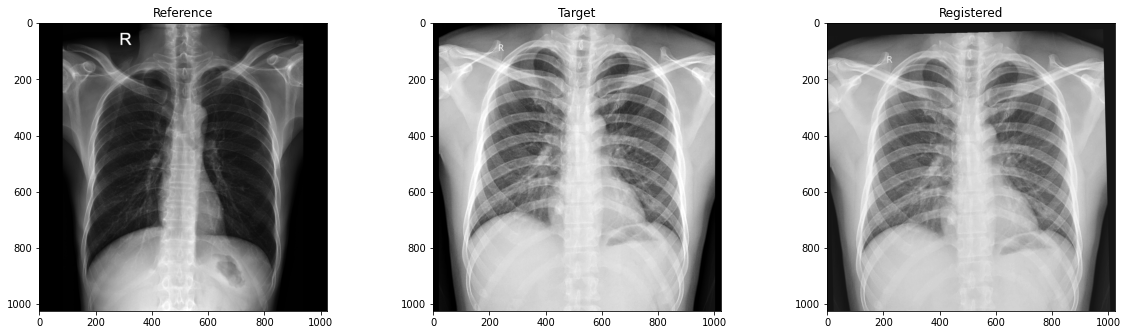

In [4]:
%%time
#Create directories
new_dir("Pngs")
new_dir("Registered_with_PyElastix")
#new_dir("Errors")
#new_dir("Stats")

d = "./Pngs/"
ref_path = './Reference/reference.png'
reference = np.asarray(Image.open(ref_path)).astype(float)
reference = shape_as(reference)
for filename in os.listdir(d):
    if filename.endswith(".png"):
        path = os.path.join('./Target/', filename)
        target = np.asarray(Image.open(path)).astype(float)
        target = shape_as(target)
        path = os.path.join('Registered_with_PyElastix', filename) 
        r = registration(target, reference,"RIGID")
        #showresults(reference, target, r)
        plt.figure(figsize=(20, 18))
        plt.subplot(3, 3, 1)
        plt.title('Reference')
        plt.imshow(reference, cmap='gray')
        plt.subplot(3, 3, 2)
        plt.title('Target')
        plt.imshow(target, cmap='gray')
        plt.subplot(3, 3, 3)
        plt.title('Registered')
        plt.imshow(r, cmap='gray')
        result = Image.fromarray(r)
        result.convert('P').save(path.replace('.png','_RIGID.png'), 'PNG')
        
    else:
        continue


### Affine Registrations

Wall time: 7min 31s


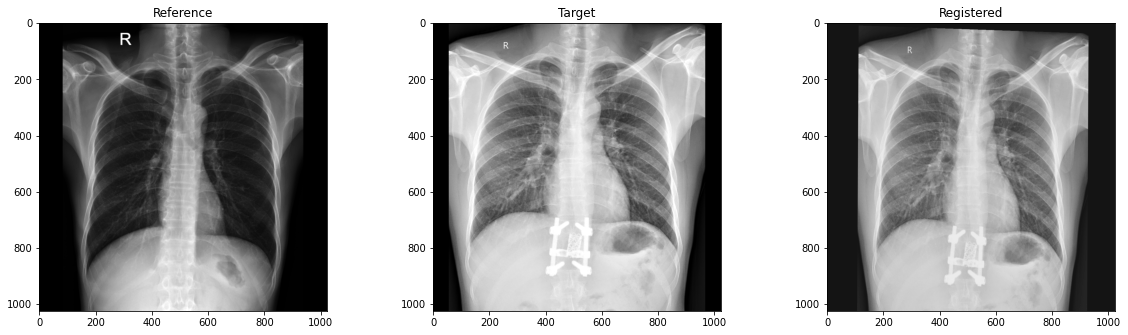

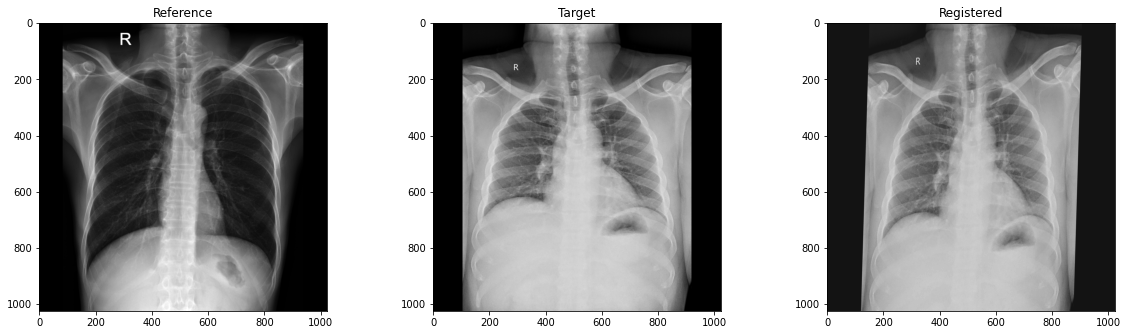

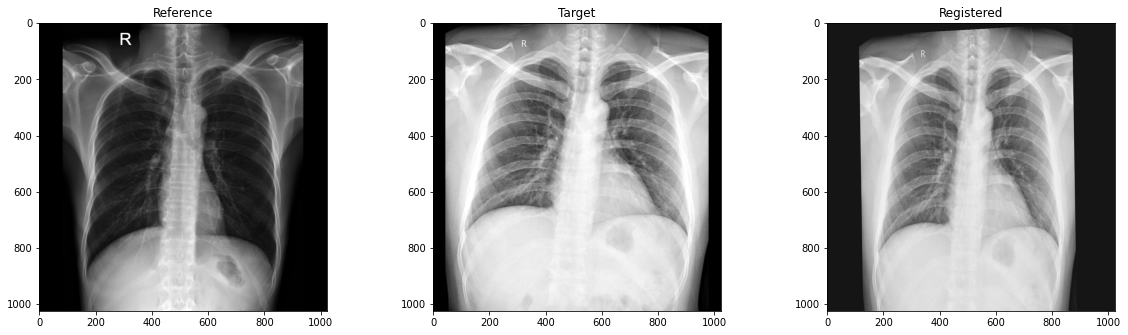

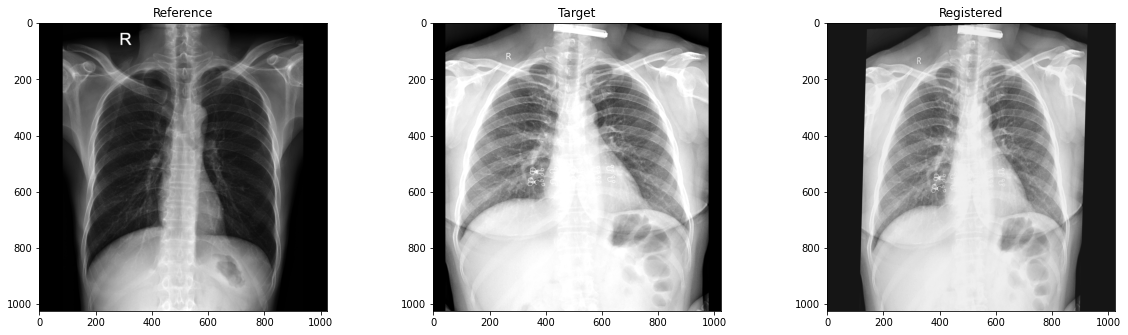

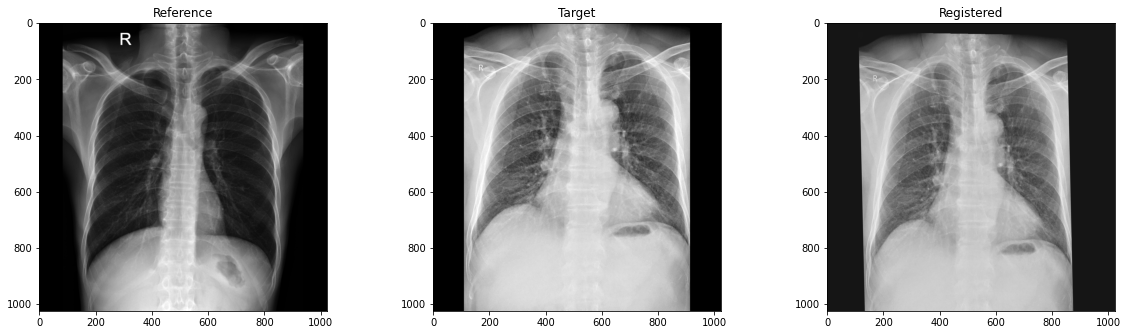

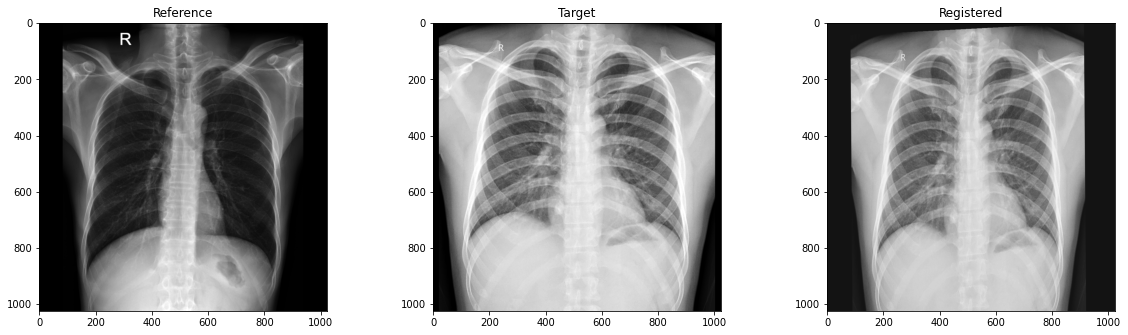

In [5]:
%%time
d = "./Pngs/"
ref_path = 'Reference\\reference.png'
reference = np.asarray(Image.open(ref_path)).astype(float)
reference = shape_as(reference)
for filename in os.listdir(d):
    if filename.endswith(".png"):
        path = os.path.join('./Target/', filename)
        target = np.asarray(Image.open(path)).astype(float)
        target = shape_as(target)
        path = os.path.join('Registered_with_PyElastix', filename) 
        r = registration(target, reference,"AFFINE")
    
        plt.figure(figsize=(20, 18))
        plt.subplot(3, 3, 1)
        plt.title('Reference')
        plt.imshow(reference, cmap='gray')
        plt.subplot(3, 3, 2)
        plt.title('Target')
        plt.imshow(target, cmap='gray')
        plt.subplot(3, 3, 3)
        plt.title('Registered')
        plt.imshow(r, cmap='gray')
        result = Image.fromarray(r)
        result.convert('P').save(path.replace('.png','_AFFINE.png'), 'PNG')
        
    else:
        continue

### NON-Rigid Registrations (B-Spline)

Wall time: 7min 28s


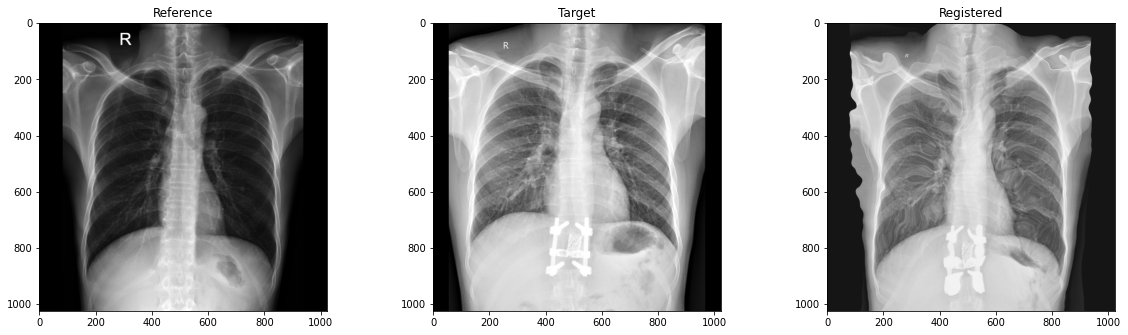

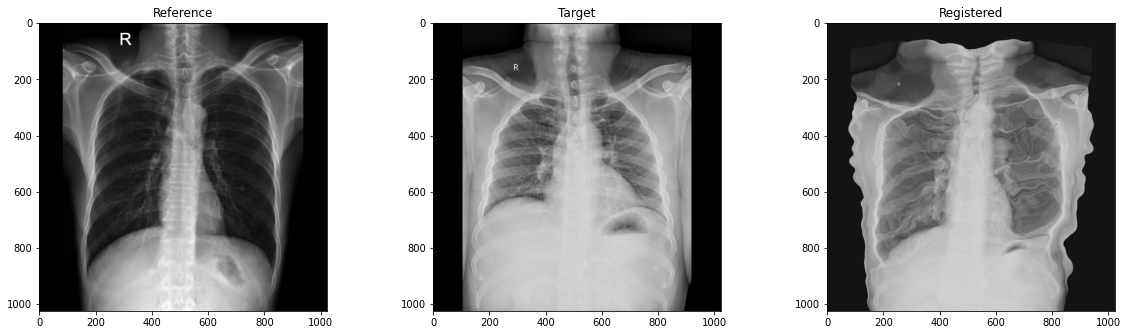

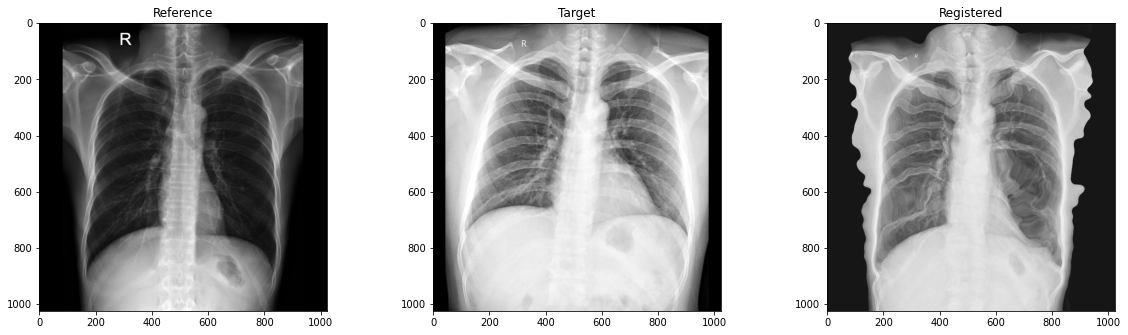

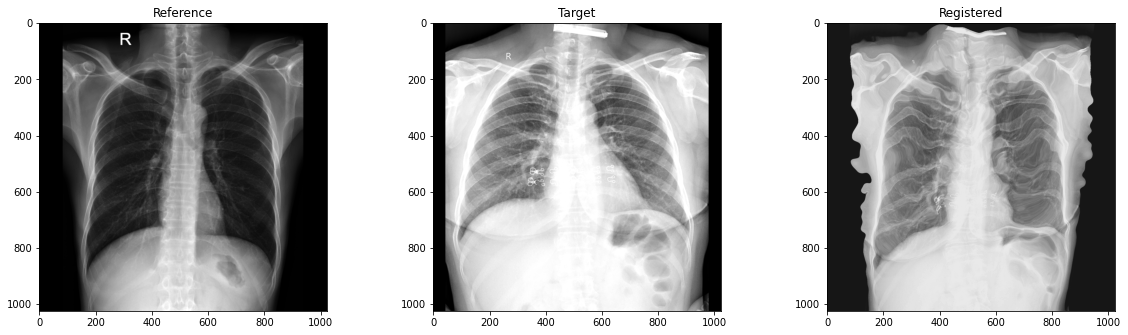

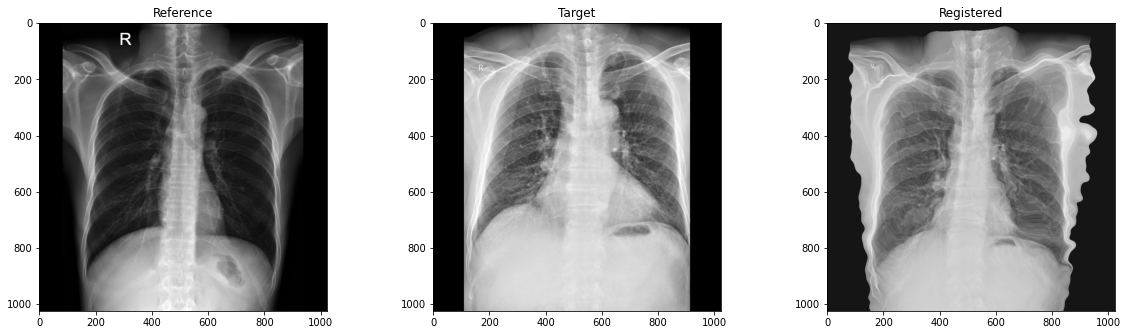

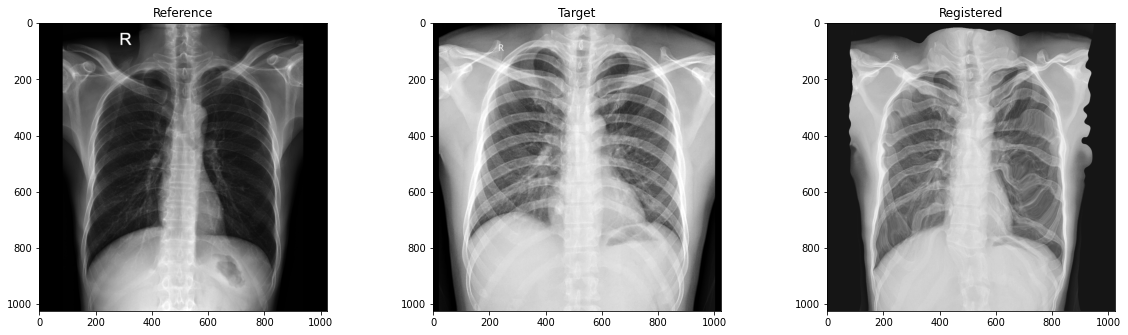

In [6]:
%%time
d = "./Pngs/"
ref_path = 'Reference\\reference.png'
reference = np.asarray(Image.open(ref_path)).astype(float)
reference = shape_as(reference)
for filename in os.listdir(d):
    if filename.endswith(".png"):
        path = os.path.join('./Target/', filename)
        target = np.asarray(Image.open(path)).astype(float)
        target = shape_as(target)
        path = os.path.join('Registered_with_PyElastix', filename) 
        r = registration(target, reference,"BSPLINE")
        plt.figure(figsize=(20, 18))
        plt.subplot(3, 3, 1)
        plt.title('Reference')
        plt.imshow(reference, cmap='gray')
        plt.subplot(3, 3, 2)
        plt.title('Target')
        plt.imshow(target, cmap='gray')
        plt.subplot(3, 3, 3)
        plt.title('Registered')
        plt.imshow(r, cmap='gray')
        result = Image.fromarray(r)
        result.convert('P').save(path.replace('.png','_BSPLINE.png'), 'PNG')
    else:
        continue

## Observations